In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout , Activation , Flatten , Conv2D , MaxPooling2D , BatchNormalization , GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from keras.optimizers import Adam
from PIL import Image
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152V2
from kaggle_datasets import KaggleDatasets


In [13]:
try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None

if tpu: 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas: ", strategy.num_replicas_in_sync)

Number of replicas:  1


In [14]:
GCS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_PATH)

train_path = GCS_PATH + '/train/train'
print(train_path)

gs://kds-ae74b6a4a3bd529807eb0eb1a4434e7b3d2b44aa7007a3e6ebca7f45
gs://kds-ae74b6a4a3bd529807eb0eb1a4434e7b3d2b44aa7007a3e6ebca7f45/train/train


In [15]:
images_path = np.array(tf.io.gfile.glob(train_path + "/*.jpg"))
print(f"loaded {len(images_path)} images" )

labels = np.array([0 if img.split('/')[-1].startswith('cat') else 1
                    for img in images_path
                  ])
print(f"loaded {len(labels)} labels" )

len(images_path) , len(labels)

loaded 25000 images
loaded 25000 labels


(25000, 25000)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

sss_train = StratifiedShuffleSplit(n_splits = 1 , test_size= 0.2 , random_state = 2020)

for train_index , val_index in sss_train.split(images_path , labels):
    train_images , val_images = images_path[train_index] , images_path[val_index] 
    train_labels , val_labels = labels[train_index] , labels[val_index]


print(f'train_images ={len(train_images)} ----- train_labels ={len(train_labels)}')
print(f'val_images ={len(val_images)} ----- val_labels ={len(val_labels)}')



train_images =20000 ----- train_labels =20000
val_images =5000 ----- val_labels =5000


In [17]:
print(labels.sum())

12500


In [18]:
CHANNELS = 3
IMG_SHAPE = (224 ,224)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SHUFFLE = 2020
NUM_CLASSES = 1
EPOCHS = 3
IMG_WEIDTH = 224
IMG_HIEGTH = 224


In [19]:
def image_processing(image_path , label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img , channels = CHANNELS)
    img = tf.image.convert_image_dtype(img , tf.float32)
    img = tf.image.resize(img, IMG_SHAPE)
    return img , label


def data_augmentation(image , label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images , train_labels))
train_ds = train_ds.map(image_processing , num_parallel_calls = AUTOTUNE)
train_ds = train_ds.map(data_augmentation , num_parallel_calls = AUTOTUNE)
train_ds = train_ds.cache().shuffle(SHUFFLE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


val_ds = tf.data.Dataset.from_tensor_slices((val_images , val_labels))
val_ds = val_ds.map(image_processing , num_parallel_calls = AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

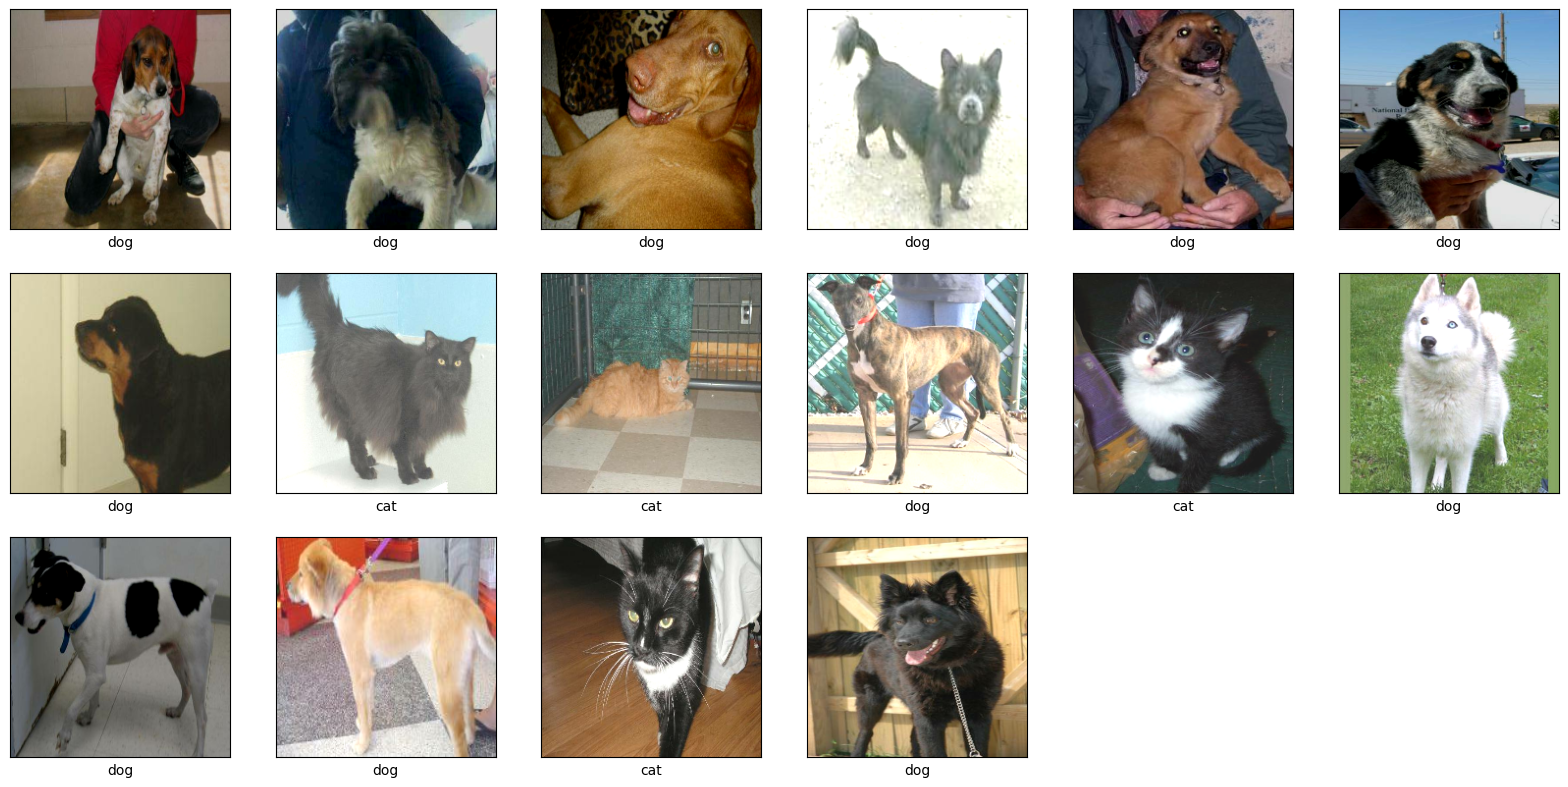

In [21]:
image,label = next(iter(train_ds))

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(6,6,i+1)
    plt.imshow(tf.clip_by_value(image[i], 0, 1))  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('cat' if label[i]==0 else 'dog')
plt.show()


In [22]:
base_model = ResNet152V2(include_top = False , weights = 'imagenet')

base_model.trainable = False

model = Sequential([
layers.InputLayer(input_shape =(IMG_HIEGTH , IMG_WEIDTH , CHANNELS)) , 
base_model , 
layers.GlobalAveragePooling2D() , 
layers.Dense(1000 , activation = 'relu') , 
layers.Dropout(0.2),
layers.Dense(NUM_CLASSES , activation = 'sigmoid')
])

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )


CALLBACKS = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=10,
                                      verbose=1,restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',
                                      factor=0.5,patience=6,verbose=1)
    ]
    

model.summary()

history = model.fit(
            train_ds ,
            batch_size = BATCH_SIZE , 
            validation_data = val_ds,
            epochs = EPOCHS ,
              callbacks = CALLBACKS
                )



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,381,649 (230.34 MB)

 Trainable params: 2,050,001 (7.82 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1368s 16s/step - accuracy: 0.9452 - loss: 0.1481 - precision: 0.9383 - recall: 0.9543 - val_accuracy: 0.9816 - val_loss: 0.0562 - val_precision: 0.9681 - val_recall: 0.9960 - learning_rate: 0.0010
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9892 - loss: 0.0267 - precision: 0.9875 - recall: 0.9906 - val_accuracy: 0.9886 - val_loss: 0.0342 - val_precision: 0.9908 - val_recall: 0.9864 - learning_rate: 0.0010
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9940 - loss: 0.0160 - precision: 0.9945 - recall: 0.9935 - val_accuracy: 0.9894 - val_loss: 0.0347 - val_precision: 0.9900 - val_recall: 0.9888 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


In [23]:
model.evaluate(val_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9896 - loss: 0.0315 - precision: 0.9896 - recall: 0.9898


[0.03467597812414169,
 0.9894000291824341,
 0.9899879693984985,
 0.9887999892234802]

In [24]:
model.save('ClassifCatsDogs99%.h5')